<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/pil_editor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from PIL import Image, ImageChops,ImageOps
import time

def sort_imgs(imgs:list):
  '''
  Sort from "0.4 < ratio < 0.76 or 1.24 < ratio < 1.6 image".
  If it's all False, Get "1.20 < ratio" image.
  
  Parametor
  ---------
  imgs : list
    PIL.Image list
  Return
  ------
  imgs : list
    PIL.Image list
  '''
  ratios = []
  results= []
  narray = np.arange(0,len(imgs))
  for i in range(len(imgs)):
    ratio = imgs[i].size[0] / imgs[i].size[1]
    ratios.append(ratio)
    result = True if 0.4 < ratio < 0.76 or 1.24 < ratio < 1.6 else False
    results.append(result)
    print(i,result,imgs[i].size,ratio)
    if result:break
    narray = np.roll(narray,-1)
    print(narray)
  print('results',results)
  if not True in results:
    for i in range(len(imgs)):
      ratio = imgs[i].size[0] / imgs[i].size[1]
      ratios.append(ratio)
      result = True if 1.20 < ratio else False
      results.append(result)
      print(i,result,imgs[i].size,ratio)
      if result:break
      narray = np.roll(narray,-1)
      print(narray)

  new_imgs = [imgs[i] for i in narray]
  return new_imgs


def resize(img,img_size):
  '''
  resize image to img_size

  Parameters
  ----------
  img : Image
    PIL Image
  img_size : int
    resize image size
  
  Returns
  -------
  image: Image
    resized image
  '''
  width = img.size[0]
  height = img.size[1]
  rate_x = img_size / width
  rate_y = img_size / height
  rate = rate_x if rate_x < rate_y else rate_y
  width = int(width * rate)
  height = int(height * rate)
  if img_size - width == 1:width = img_size
  if img_size - height == 1:hegith = img_size
  return img.resize((width,height), Image.ANTIALIAS)

def crop_image(path:str)->Image:
  image = Image.open(path)
  # getpixel(0, 0) で左上の色を取得し、背景色のみの画像を作成する
  bgc = image.getpixel((0, 0))
  print('bgc',bgc)
  bg = Image.new(image.mode, image.size,bgc)

  fix_image = ImageOps.autocontrast(image,0.5)
  # 背景色画像と元画像の差分を取得
  diff = ImageChops.difference(fix_image, bg)
  diff = ImageChops.add(diff, diff, 2.0, -100)
  # 黒背景の境界Boxを取り出す
  bbox = diff.getbbox()
  # 元画像を切り出す
  cropped = image.crop(bbox)
  return cropped


def triple_images(imgs,img_size):
  x,y,x1,y1 = 0,0,0,0

  # image 1
  imgs[0] = resize(imgs[0],img_size)
  print('imgs[0].size',imgs[0].size)

  space_x = img_size - imgs[0].size[0]
  if space_x == 0:
    space_y = img_size - imgs[0].size[1]
    space_x = img_size
  else:
    space_x = img_size - imgs[0].size[0]
    space_y = img_size
  print('space_x',space_x,'space_y',space_y)
  imgs[1].thumbnail((space_x,space_y))

  if imgs[0].size[0] != img_size: x1 = imgs[0].size[0] 
  if imgs[0].size[1] != img_size: y1 = imgs[0].size[1] 
  print('x1',x1,'y1',y1)

  # image 2
  print('imgs[1].size',imgs[1].size)
  x2,y2 = x1,y1
  if x1 == 0: x2 = imgs[1].size[0]
  if y1 == 0: y2 = imgs[1].size[1]
  if x1 == x2 and y2 == img_size:
    x2 = imgs[0].size[0] + imgs[1].size[0] 
    y2 = 0
  if y1 == y2 and x2 == img_size:
    y2 = imgs[0].size[1] + imgs[1].size[1]
    x2 = 0
  print('x2',x2,'y2',y2)

  space_x = img_size - x2
  space_y = img_size - y2
  if space_x == 0:space_x = img_size
  if space_y == 0:space_y = img_size
  print('space_x',space_x,'space_y',space_y)

  imgs[2].thumbnail((space_x,space_y))
  print('imgs[2]',imgs[2].size)

  # make background
  bgc = imgs[0].getpixel((imgs[0].size[0]-1,imgs[0].size[1]-1))
  bg = Image.new('RGB',(img_size,img_size),bgc)

  xm,ym = 0,0
  if imgs[0].size[0] == img_size: 
    xm = img_size - imgs[1].size[0] - imgs[2].size[0] 
    xm = int(xm/2)
  if imgs[0].size[1] == img_size: 
    ym = img_size - imgs[1].size[1] - imgs[2].size[1] 
    ym = int(ym/2)
  if xm < 0:xm = 0
  if ym < 0:ym = 0
  print('xm,ym',xm,ym)

  x_weight = imgs[1].size[0]/img_size
  y_weight = imgs[1].size[1]/img_size
  print('x_weight',x_weight,'y_weight',y_weight)

  x_weight2 = imgs[2].size[0]/img_size
  y_weight2 = imgs[2].size[1]/img_size
  print('x_weight2',x_weight2,'y_weight2',y_weight2)    

  bg.paste(imgs[0],(x,y)  ) # image 1
  if x_weight > 0.15 and y_weight > 0.15:bg.paste(imgs[1],(xm + x1,ym + y1)) # image 2
  if x_weight2 > 0.15 and y_weight2 > 0.15:bg.paste(imgs[2],(xm + x2,ym + y2)) # image 3

  # if 3 < len(imgs) and x_weight2 > 0.15 and y_weight2 > 0.15 and xm == 0 and ym == 0 and imgs[0].size[1] == img_size:
  #   if img_size * 2 == imgs[0].size[1] + imgs[1].size[1]:
  #     print('img_size * 2')
  #     x3 = imgs[0].size[0] + imgs[1].size[0]
  #     y3 = imgs[2].size[1]
  #   else:
  #     print('not img_size * 2')
  #     x3 = imgs[0].size[0] + imgs[1].size[0]
  #     y3 = img_size
  #   print('x3',x3,'y3',y3)
  #   imgs[3].thumbnail((img_size - x3,img_size - y3))
  #   if img_size / 3 < imgs[3].size[0] or img_size / 3 < imgs[3].size[1]:
  #     bg.paste(imgs[3],(x3,y3)) # image 3
  return bg

bgc (230, 230, 230)
bgc (228, 227, 225)
bgc (242, 242, 242)
bgc (226, 226, 226)
0 False (1990, 2040) 0.9754901960784313
[1 2 3 0]
1 False (1840, 2336) 0.7876712328767124
[2 3 0 1]
2 False (2176, 2777) 0.7835794022326251
[3 0 1 2]
3 False (2062, 927) 2.2243797195253507
[0 1 2 3]
results [False, False, False, False]
0 False (1990, 2040) 0.9754901960784313
[1 2 3 0]
1 False (1840, 2336) 0.7876712328767124
[2 3 0 1]
2 False (2176, 2777) 0.7835794022326251
[3 0 1 2]
3 True (2062, 927) 2.2243797195253507
imgs[0].size (500, 224)
space_x 500 space_y 276
x1 0 y1 224
imgs[1].size (269, 276)
x2 269 y2 224
space_x 231 space_y 276
imgs[2] (217, 276)
xm,ym 7 0
x_weight 0.538 y_weight 0.552
x_weight2 0.434 y_weight2 0.552
1.9062271118164062


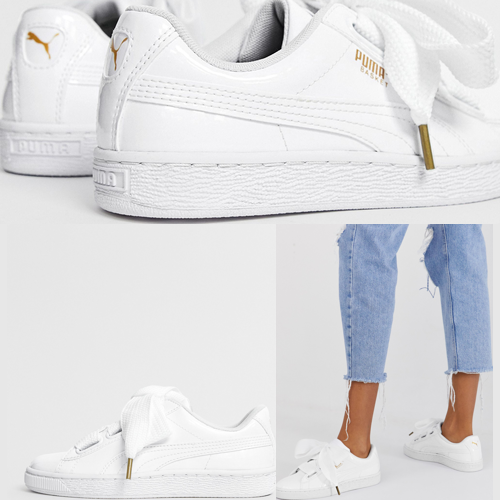

In [62]:
img_paths = ['/content/a02.jpg','/content/a01.jpg','/content/a03.jpg','/content/a03.jpg']
img_paths = ['/content/a01.jpg','/content/a02.jpg','/content/a03.jpg','/content/a03.jpg']
img_paths = ['/content/004/a01.jpg','/content/004/a02.jpg','/content/004/a03.jpg','/content/004/a04.jpg']
# img_paths = ['/content/002/a01.jpg','/content/002/a02.jpg','/content/002/a03.jpg']
# img_paths = ['/content/002/a01.jpg','/content/002/a02.jpg','/content/002/a03.jpg']
# img_paths = ['/content/12030065/a03.jpg','/content/12030065/a02.jpg','/content/12030065/a01.jpg','/content/12030065/a04.jpg']
# img_paths = ['/content/8934106/a03.jpg','/content/8934106/a01.jpg','/content/8934106/a02.jpg','/content/8934106/a04.jpg']
# img_paths = ['/content/11004955/a04.jpg','/content/11004955/a02.jpg','/content/11004955/a01.jpg','/content/11004955/a03.jpg']
# img_paths = ['/content/11006540/a03.jpg','/content/11006540/a02.jpg','/content/11006540/a01.jpg','/content/11006540/a04.jpg']
# img_paths = ['/content/11004770/a01.jpg','/content/11004770/a04.jpg','/content/11004770/a03.jpg','/content/11004770/a02.jpg']
# img_paths = ['/content/11063515/a01.jpg','/content/11063515/a02.jpg','/content/11063515/a03.jpg','/content/11063515/a04.jpg']
# img_paths = ['/content/10589422/a03.jpg','/content/10589422/a02.jpg','/content/10589422/a04.jpg','/content/10589422/a01.jpg']
# img_paths = ['/content/10990068/a03.jpg','/content/10990068/a02.jpg','/content/10990068/a01.jpg','/content/10990068/a04.jpg']
# img_paths = ['/content/10990068/a01.jpg','/content/10990068/a02.jpg','/content/10990068/a03.jpg','/content/10990068/a04.jpg']
start = time.time()
imgs = [crop_image(path) for path in img_paths]
imgs = sort_imgs(imgs)
img_size = 500
new_image = triple_images(imgs,img_size)
print(time.time() - start)
new_image

In [0]:
!unzip test_sample.zip

In [5]:
!unzip error_sample.zip

unzip:  cannot find or open error_sample.zip, error_sample.zip.zip or error_sample.zip.ZIP.


In [37]:
!unzip 004.zip

Archive:  004.zip
replace 001/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
   creating: 003/
  inflating: 003/a04.jpg             
   creating: __MACOSX/003/
  inflating: __MACOSX/003/._a04.jpg  
  inflating: 003/a02.jpg             
  inflating: __MACOSX/003/._a02.jpg  
  inflating: 003/a03.jpg             
  inflating: __MACOSX/003/._a03.jpg  
  inflating: 003/a01.jpg             
  inflating: __MACOSX/003/._a01.jpg  
   creating: 004/
  inflating: 004/a04.jpg             
   creating: __MACOSX/004/
  inflating: __MACOSX/004/._a04.jpg  
  inflating: 004/a02.jpg             
  inflating: __MACOSX/004/._a02.jpg  
  inflating: 004/a03.jpg             
  inflating: __MACOSX/004/._a03.jpg  
  inflating: 004/a01.jpg             
  inflating: __MACOSX/004/._a01.jpg  


In [41]:
img_paths = ['/content/004/a01.jpg','/content/004/a02.jpg','/content/004/a03.jpg','/content/004/a04.jpg']
imgs = [crop_image(path) for path in img_paths]
imgs = sort_imgs(imgs)

bgc (230, 230, 230)
bgc (228, 227, 225)
bgc (242, 242, 242)
bgc (226, 226, 226)
0 False (1990, 2040) 0.9754901960784313
[1 2 3 0]
1 True (1840, 2336) 0.7876712328767124


In [0]:
results= [False,False,False]
if not True in results:
  print(False)